<a href="https://colab.research.google.com/github/Jang-Boa/Deep_Learning/blob/main/LungImage_segment_2%E1%84%8E%E1%85%A1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
!wget https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip

--2021-10-30 05:15:34--  https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip [following]
--2021-10-30 05:15:34--  https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56097894 (53M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  53.

In [2]:
!unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
  inflating: image/resize_CHNCXR_0001_0.png  
  inflating: image/resize_CHNCXR_0002_0.png  
  inflating: image/resize_CHNCXR_0003_0.png  
  inflating: image/resize_CHNCXR_0004_0.png  
  inflating: image/resize_CHNCXR_0005_0.png  
  inflating: image/resize_CHNCXR_0006_0.png  
  inflating: image/resize_CHNCXR_0007_0.png  
  inflating: image/resize_CHNCXR_0008_0.png  
  inflating: image/resize_CHNCXR_0009_0.png  
  inflating: image/resize_CHNCXR_0010_0.png  
  inflating: image/resize_CHNCXR_0011_0.png  
  inflating: image/resize_CHNCXR_0012_0.png  
  inflating: image/resize_CHNCXR_0013_0.png  
  inflating: image/resize_CHNCXR_0014_0.png  
  inflating: image/resize_CHNCXR_0015_0.png  
  inflating: image/resize_CHNCXR_0016_0.png  
  inflating: image/resize_CHNCXR_0017_0.png  
  inflating: image/resize_CHNCXR_0018_0.png  
  inflating: image/resize_CHNCXR_0019_0.png  
  inflating: image/resize_CHNCXR_0020_0.png  
  inflating: image/resize_CHNCXR_0021_0.png  
  

# Read image

In [3]:
### >>> Code <<< ###
import os 

# image_shape = (image_height, image_width, image_channel)
image_height = 256
image_width = 256
image_channel = 3

# image_size = (256,256)
num_classes = 3 # right and left and background
# batch_size = 32

image_dir = 'image'
label_dir = 'label'

image_file = os.listdir(image_dir)
label_file = os.listdir(label_dir)

img_head = []
for i in image_file:
  name = os.path.splitext(i)[0]
  file_type = os.path.splitext(i)[1]
  img_head.append(name)

image_path = []
label_path = []
for fh in img_head:
  image_path.append(os.path.join(image_dir,fh+file_type))
  label_path.append(os.path.join(label_dir,fh+file_type))

# image_path = [os.path.join(image_dir,fname) for fname in os.listdir(image_dir)] -> 순서를 정렬할 이유가 없다.. 섞어줘야 하기 때문에 random sampling 
# label_path = [os.path.join(label_dir, fname) for fname in os.listdir(label_dir)]
img_num = len(img_head)
print(f'총 이미지의 갯수: {img_num}, 이미지 확장자: {file_type}')

총 이미지의 갯수: 566, 이미지 확장자: .png


In [4]:
image_file[1]

'resize_CHNCXR_0581_1.png'

# Check Image

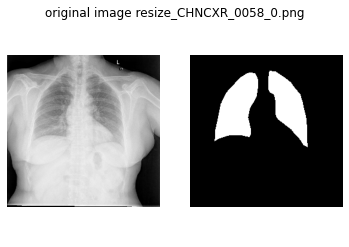

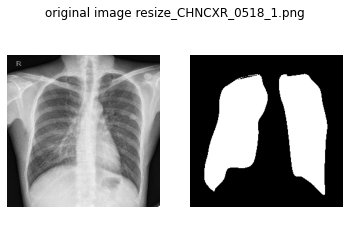

In [5]:
### >>> Code <<< ###
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Seed 고정
seed = 42
random.seed(seed)

for i in random.sample(range(img_num),2):

  fig = plt.figure()
  plt.title(f'original image {image_file[i]}')
  plt.axis('off')

  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(load_img(image_path[i]))
  # ax1.set_title(f'original image {image_file[1]}')
  ax1.axis('off')

  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(load_img(label_path[i]))
  # ax2.set_title(f'label image {label_file[1]}')
  ax2.axis('off')

  plt.show()

# 이미지 세분화 

In [6]:
### >>> Code <<< ###
from scipy import ndimage as ndi
import collections

def region_based_segmentation(path):
  """ 
  영역을 기반으로 라벨을 나누어 준다. 
  """

  img = load_img(path, target_size=(image_height, image_width),color_mode='grayscale') 
  img = img_to_array(img) # image -> array(256,256,1)

  labels, nlabels = ndi.label(img) # labels => (256,256,1), nlabels = number of labels

  return labels, nlabels

##
def left_and_right(labels, top):
  """
  이미지의 왼쪽과 오른쪽으로 구분
  left => 1, right -> 2
  """
  left = 1
  right = 2

  a = np.where(labels==top[1]) # -> 배경을 제외하고 top 중 라벨이 많은 것
  b = np.where(labels==top[2]) # -> 라벨이 적은 것

  x1 = a[0]
  y1 = a[1]
  z1 = a[2]
  x2 = b[0]
  y2 = b[1]
  z2 = b[2]

  if y1[0] < y2[0]: # a-> left, b-> right
    for m in range(len(x1)):
      labels[x1[m], y1[m], z1[m]] = left
    for n in range(len(x2)):
      labels[x2[n], y2[n], z2[n]] = right

  else: # a-> rigjt, b->left
    for m in range(len(x1)):
      labels[x1[m], y1[m], z1[m]] = right
    for n in range(len(x2)):
      labels[x2[n], y2[n], z2[n]] = left

  return labels

##
def segment_label(path):
  """
  이미지 세분화 작업 후 이미지 처리 과정 -> 라벨 정리
  """
  labels, nlabels = region_based_segmentation(path)

  unique, counts = np.unique(labels,return_counts=True) # ndarray 에 존재하는 요소의 값과 갯수를 리스트로 반환

  # count로 많은 순서대로 정렬 및 그에 해당하는 라벨을 리턴
  idx_order = np.argsort(-counts) # 갯수가 많은 순으로 라벨을 정리
  num_order = np.sort(counts)[::-1] # 갯수가 많은 순으로 갯수를 정리

  top = idx_order[:3] # top 3 개의 라벨만 골라서 리스트에 정리

  # label은 background, right, left 로 3[0-2]개가 생성되야 한다. 
  if nlabels > 2: # label의 갯수가 많은 경우
    lst = [unique[idx] for idx in range(len(counts)) if counts[idx] < 20] # 라벨의 갯수가 20보다 작은 라벨들 
    
    for x in range(256):
      for y in range(256):
        if labels[x,y,0] in lst:
          labels[x,y,0] = 0 # 갯수가 20보다 적은 라벨은 배경으로 치환
        elif (labels[x,y,0] not in top) and (labels[x,y,0] not in lst):
          labels[x,y,0] = top[-1] # 계산 필요... -> 20 보다 큰 값의 라벨은 어디에 속할지 정해주어야 한다.
    
  labels = left_and_right(labels,top)

  return labels

In [7]:
### >>> Code <<< ###
# data 정리
X = np.zeros((img_num,image_height,image_width,image_channel),dtype='float32')
y = np.zeros((img_num,image_height,image_width,1),dtype='float32')

for j, path in enumerate(img_head):
  image = load_img(os.path.join(image_dir,path+file_type))
  image = img_to_array(image)/255.
  X[j] = image

  label = segment_label(os.path.join(label_dir,path+file_type)) # segment function
  y[j] = label

In [8]:
X.shape, y.shape

((566, 256, 256, 3), (566, 256, 256, 1))

In [9]:
# # to check image is seperated well into right and left
# count = 0
# for j in range(img_num): 
#   arr = y[j].flatten()
#   a = 0
#   b = 0
#   c = 0
#   d = 0
#   for i in arr:
#     if i == 0:
#       a += 1
#     elif i == 1:
#       b += 1
#     elif i == 2:
#       c += 1
#     else:
#       d += 1 
#   if d != 0:
#     print(j)
#     count += 1

# # print(a,b,c,d)
# # print(a+b+c+d)
# # print(len(arr), arr.size)
# print(count)

# Split DataSet

In [10]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_val, y_train, y_val  = train_test_split(X, y, test_size=test_size, random_state=seed)
X_train, X_test, y_train,y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=seed)

print(f"""train num: {len(X_train)}
validation num: {len(X_val)}
test num: {len(X_test)}""")

train num: 361
validation num: 114
test num: 91


In [11]:
X_train.shape, y_train.shape

((361, 256, 256, 3), (361, 256, 256, 1))

# Check Image

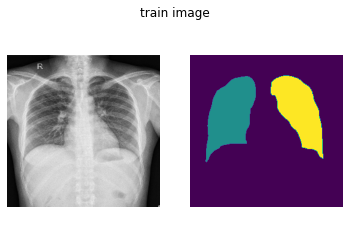

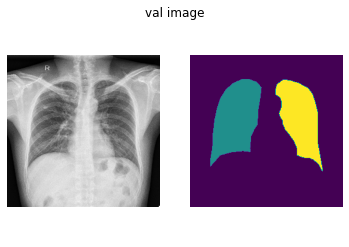

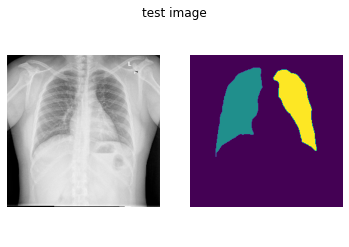

In [12]:
from tensorflow.keras.preprocessing.image import array_to_img
i = random.randint(0,3)

fig1 = plt.figure()
plt.title('train image')
plt.axis('off')
fig2 = plt.figure()
plt.title('val image')
plt.axis('off')
fig3 = plt.figure()
plt.title('test image')
plt.axis('off')

# train image
ax1 = fig1.add_subplot(1,2,1)
ax1.imshow(array_to_img(X_train[i]))
ax1.axis('off')

ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(array_to_img(y_train[i]))
ax2.axis('off')

# val image
ax3 = fig2.add_subplot(1,2,1)
ax3.imshow(array_to_img(X_val[i]))
ax3.axis('off')

ax4 = fig2.add_subplot(1,2,2)
ax4.imshow(array_to_img(y_val[i]))
ax4.axis('off')

# test image
ax5 = fig3.add_subplot(1,2,1)
ax5.imshow(array_to_img(X_test[i]))
ax5.axis('off')

ax6 = fig3.add_subplot(1,2,2)
ax6.imshow(array_to_img(y_test[i]))
ax6.axis('off')

plt.show()

# Create Model

In [13]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, Conv2DTranspose
from keras import Model

def unet(image_height, image_width, num_classes):
    # inputs = Input(input_size)
    inputs = Input(shape=(image_height, image_width, 3),name='U-net')
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)
    # output-> 다수의 클래스를 분류해야 하기 때문에 softmax 활성함수를 사용합니다. 

    return Model(inputs=[inputs], outputs=[outputs])

In [14]:
unet_model = unet(image_height, image_width, num_classes)
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
U-net (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         U-net[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Train Model

In [15]:
from tensorflow.keras import optimizers
sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9,nesterov=True)
unet_model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# optimizer에 대한 공부는 아직 필요합니다 -> 지수 이동 평균을 적용했다고 한다. 정리 필요한 부분
# loss-> classification 문제
# sparse_categorical_crossentropy -> 다중 분류 손실함수이다.

# checkpoint 로 중간에 괜찮은 결과를 저장
callbacks = [keras.callbacks.ModelCheckpoint('unet.h5', save_best_only=True)]


In [37]:
# epochs
epochs = 50
batch_size = 16
hist = unet_model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_val,y_val), callbacks=callbacks)

# save_weights
unet_model.save_weights('Unet_model.h5')

Epoch 1/50
23/23 [==============================] - 14s 596ms/step - loss: 0.0593 - accuracy: 0.9772 - val_loss: 0.0564 - val_accuracy: 0.9790
Epoch 2/50
23/23 [==============================] - 14s 594ms/step - loss: 0.0593 - accuracy: 0.9771 - val_loss: 0.0593 - val_accuracy: 0.9777
Epoch 3/50
23/23 [==============================] - 14s 594ms/step - loss: 0.0580 - accuracy: 0.9775 - val_loss: 0.0549 - val_accuracy: 0.9795
Epoch 4/50
23/23 [==============================] - 14s 594ms/step - loss: 0.0596 - accuracy: 0.9771 - val_loss: 0.0563 - val_accuracy: 0.9787
Epoch 5/50
23/23 [==============================] - 14s 594ms/step - loss: 0.0597 - accuracy: 0.9771 - val_loss: 0.0549 - val_accuracy: 0.9797
Epoch 6/50
23/23 [==============================] - 14s 592ms/step - loss: 0.0591 - accuracy: 0.9771 - val_loss: 0.0549 - val_accuracy: 0.9795
Epoch 7/50
23/23 [==============================] - 14s 593ms/step - loss: 0.0579 - accuracy: 0.9775 - val_loss: 0.0547 - val_accuracy: 0.9797

# 학습 결과

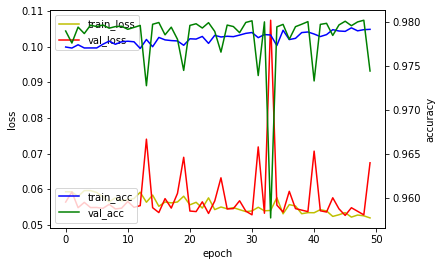

In [38]:
# 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'y',label='train_loss')
loss_ax.plot(hist.history['val_loss'],'r',label='val_loss')

acc_ax.plot(hist.history['accuracy'],'b',label='train_acc')
acc_ax.plot(hist.history['val_accuracy'],'g',label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [39]:
# 모델 평가
score = unet_model.evaluate(X_test,y_test, verbose=1)
print('정답률 = ', score[1],'loss=', score[0])

3/3 [==============================] - 1s 352ms/step - loss: 0.0816 - accuracy: 0.9699
정답률 =  0.9699074625968933 loss= 0.08158117532730103


# Predict Result

In [40]:
from tensorflow.keras.preprocessing.image import array_to_img

preds = unet_model.predict(X_test)

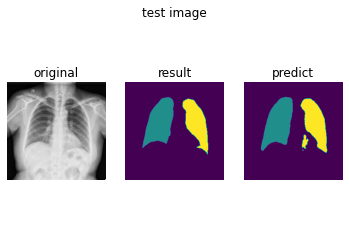

In [41]:
# test image
i = random.randint(0,3)

fig = plt.figure()
plt.title('test image')
plt.axis('off')

# original
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(array_to_img(X_test[i]))
ax1.set_title('original')
ax1.axis('off')
# result
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(array_to_img(y_test[i]))
ax2.set_title('result')
ax2.axis('off')
# predict
p = np.argmax(preds[i],axis=-1)
p = np.expand_dims(p,axis=-1)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(array_to_img(p))
ax3.set_title('predict')
ax3.axis('off')

plt.show()

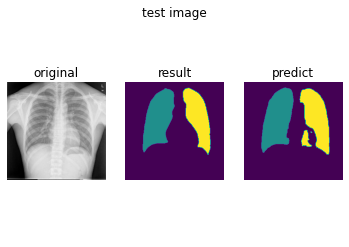

In [42]:
# test image
i = 13

fig = plt.figure()
plt.title('test image')
plt.axis('off')

# original
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(array_to_img(X_test[i]))
ax1.set_title('original')
ax1.axis('off')
# result
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(array_to_img(y_test[i]))
ax2.set_title('result')
ax2.axis('off')
# predict
p = np.argmax(preds[i],axis=-1)
p = np.expand_dims(p,axis=-1)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(array_to_img(p))
ax3.set_title('predict')
ax3.axis('off')

plt.show()

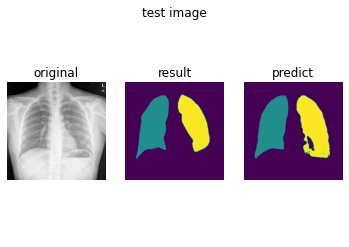

In [43]:
# test image
i = 25

fig = plt.figure()
plt.title('test image')
plt.axis('off')

# original
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(array_to_img(X_test[i]))
ax1.set_title('original')
ax1.axis('off')
# result
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(array_to_img(y_test[i]))
ax2.set_title('result')
ax2.axis('off')
# predict
p = np.argmax(preds[i],axis=-1)
p = np.expand_dims(p,axis=-1)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(array_to_img(p))
ax3.set_title('predict')
ax3.axis('off')

plt.show()

In [ ]:
# # Tensor Board와 연결하기
# tb_hist = keras.callbacks.TensorBoard(log_dir='./graph',histogram_freq=0,write_graph=True, write_images=True)
# model.fit(X_train,y_train,epochs=1000,batch_size=10,validation_data=(X_val,y_val),callbacks=[tb_hist])

In [ ]:
# # 모델 불러오기
# from keras.models import load_model
# model = load_model('Unet_model.h5')

# y_pred = model.predic(X_test)